https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/#:~:text=In%20the%202014%20ImageNet%20Classification,present%20in%20our%20Food%20dataset.

In [1]:
import os
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras import layers, models, Model, optimizers
from PIL import ImageFile,Image
from keras.layers import Dense, Dropout, Flatten
import tensorflow as tf
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet import ResNet50

import datetime
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
BATCH_SIZE = 64

train_generator =ImageDataGenerator( validation_split=0.15,
                                    #rescale=1./255,
                                   preprocessing_function=preprocess_input )

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # MobileNetV2

In [3]:
train_data_dir ='D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Training/'
test_data_dir = 'D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/'

total_classes = sorted(os.listdir(train_data_dir))
print(total_classes)


['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

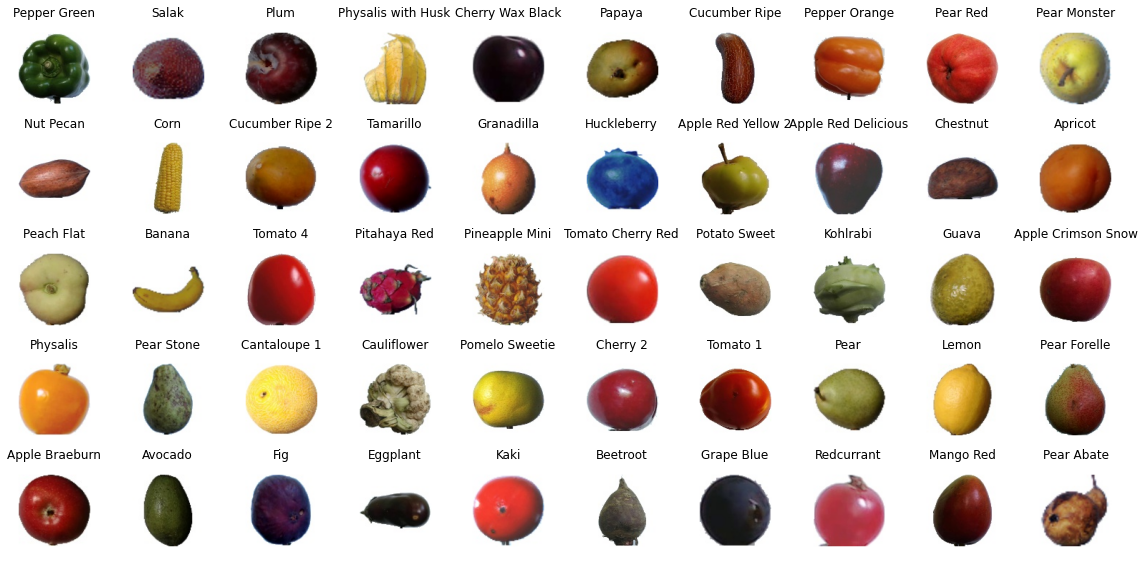

In [62]:
import random, cv2
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Training/')

# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 50)

# Iterating through all the generated random values.
for counter, random_index in enumerate((random_range),1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Training/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    #video_reader = cv2.(f'D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Training/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    img = cv2.imread(f'D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Training/{selected_class_Name}/{selected_video_file_name}')
    old_image_height, old_image_width, channels = img.shape

    # create new image of desired size and color (blue) for padding
    new_image_width = 130
    new_image_height = 130
    color = (255,255,255)
    result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)

    # compute center offset
    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2

    # copy img image into center of result image
    result[y_center:y_center+old_image_height, 
       x_center:x_center+old_image_width] = img
    
    
    # Release the VideoCapture object. 
    #video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    #cv2.imwrite(selected_class_Name+'.jpg',rgb_frame)
    #cv2.putText(rgb_frame, selected_class_Name, (30, 120), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 0), 2)
    
    # Display the frame.
    plt.subplot(10, 10, counter);plt.gca().set_title(selected_class_Name);plt.imshow(rgb_frame);plt.axis('off')

In [61]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(100, 100),
                                               class_mode='categorical',
                                               classes=total_classes,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(100, 100),
                                               class_mode='categorical',
                                               classes=total_classes,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(100, 100),
                                             class_mode=None,
                                             classes=total_classes,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 57612 images belonging to 131 classes.
Found 10080 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [5]:
from tensorflow.keras import models
vgg_model = models.load_model('D:/TQ/Fruits360/VGG_Model_10_Epochs_FineTuned2.h5')

In [6]:
# Confusion Matrix
start = datetime.datetime.now()
Y_pred = vgg_model.predict(testgen)
y_pred = np.argmax(Y_pred, axis=1)


22688/22688 [==============================] - 865s 38ms/step


In [7]:
true_classes = testgen.classes

vgg_acc_ft = accuracy_score(true_classes, y_pred)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))

VGG16 Model Accuracy with Fine-Tuning: 97.09%


In [8]:
report = classification_report(testgen.classes, y_pred, target_names=total_classes)
print(report)

                     precision    recall  f1-score   support

     Apple Braeburn       1.00      1.00      1.00       164
 Apple Crimson Snow       1.00      0.99      0.99       148
     Apple Golden 1       0.95      1.00      0.98       160
     Apple Golden 2       0.90      1.00      0.95       164
     Apple Golden 3       0.77      1.00      0.87       161
 Apple Granny Smith       0.88      0.84      0.86       164
    Apple Pink Lady       0.92      1.00      0.96       152
        Apple Red 1       1.00      1.00      1.00       164
        Apple Red 2       1.00      1.00      1.00       164
        Apple Red 3       1.00      0.78      0.88       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.86      1.00      0.92       164
 Apple Red Yellow 2       0.99      0.92      0.95       219
            Apricot       1.00      1.00      1.00       164
            Avocado       0.93      1.00      0.97       143
       Avocado ripe    

In [9]:
file_names=testgen.filenames  # save list of test files names to be used later
tlabels=testgen.labels # save test labels to be used later
class_dict=testgen.class_indices
# code below determines test batch size and test steps
# so you go through the test images exactly once
length=len(file_names) # determine number of images
b_max=80 # set maximum batch size you will allow
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=b_max],reverse=True)[0]
test_steps=int(length/BATCH_SIZE)
# make predictions
preds=Y_pred
new_dict={} 
for key in class_dict: # set key in new_dict to value in class_dict and value in new_dict to key in class_dict
    value=class_dict[key]
    new_dict[value]=key
error_list=[] # empty list to store if the prediction was correct or not
true_predictions = {}
false_predictions = {}
error_file_list=[]
a = b = 1
for i, p in enumerate(preds):
    pred_index=np.argmax(p) # get the index that has the highest probability
    if pred_index == tlabels[i]: #correct predictions
      true_predictions[a] = {}
      true_predictions[a]['PredictedClass'] = new_dict[pred_index]
      true_predictions[a]['TrueClass'] = new_dict[tlabels[i]]
      true_predictions[a]['FileName'] = file_names[i]
      true_predictions[a]['Status'] = 'No'
      error_list.append('No')
      a+=1
    else:
      error_list.append('Yes')
      false_predictions[b] = {}
      false_predictions[b]['PredictedClass'] = new_dict[pred_index]
      false_predictions[b]['TrueClass'] = new_dict[tlabels[i]]
      false_predictions[b]['FileName'] = file_names[i]
      false_predictions[b]['Status'] = 'Yes'
      b+=1
      #print(f'    {pred_class:10s}       {true_class:10s}    {file:25s}   {error_status:10s}')  
      
print("Total Images: ",len(error_list))
print("True Predictions: ",len(true_predictions))
print("False Predictions: ",len(false_predictions))

Total Images:  22688
True Predictions:  22027
False Predictions:  661


In [10]:
print("---------------False Predictions---------")
print('PREDICTED CLASS            TRUE CLASS         FILENAME                        STATUS' ) # adjust spacing based on your class names
for i in range(45,78):
  pred_class = false_predictions[i]['PredictedClass']  # find the predicted class based on the index
  true_class = false_predictions[i]['TrueClass'] # use the test label to get the true class of the test file
  file = false_predictions[i]['FileName']
  status = false_predictions[i]['Status']
  print(f'    {pred_class:10s}       {true_class:10s}    {file:25s}   {status:10s}') 

---------------False Predictions---------
PREDICTED CLASS            TRUE CLASS         FILENAME                        STATUS
    Peach            Apple Red 3    Apple Red 3\84_100.jpg      Yes       
    Peach            Apple Red 3    Apple Red 3\85_100.jpg      Yes       
    Peach            Apple Red 3    Apple Red 3\86_100.jpg      Yes       
    Peach            Apple Red 3    Apple Red 3\87_100.jpg      Yes       
    Peach            Apple Red 3    Apple Red 3\88_100.jpg      Yes       
    Peach            Apple Red 3    Apple Red 3\89_100.jpg      Yes       
    Peach            Apple Red 3    Apple Red 3\90_100.jpg      Yes       
    Peach            Apple Red 3    Apple Red 3\91_100.jpg      Yes       
    Peach            Apple Red 3    Apple Red 3\92_100.jpg      Yes       
    Peach            Apple Red 3    Apple Red 3\93_100.jpg      Yes       
    Peach            Apple Red 3    Apple Red 3\94_100.jpg      Yes       
    Peach            Apple Red 3    Apple Red 3\

In [11]:
print("---------------------True Predictions--------------------\n")
print('PREDICTED CLASS            TRUE CLASS         FILENAME                        STATUS' ) # adjust spacing based on your class names
for i in range(1,20765):
  pred_class = true_predictions[i]['PredictedClass']  # find the predicted class based on the index
  true_class = true_predictions[i]['TrueClass'] # use the test label to get the true class of the test file
  file = true_predictions[i]['FileName']
  status = true_predictions[i]['Status']
  print(f'    {pred_class:10s}       {true_class:10s}    {file:25s}   {status:10s}') 

---------------------True Predictions--------------------

PREDICTED CLASS            TRUE CLASS         FILENAME                        STATUS
    Apple Braeburn       Apple Braeburn    Apple Braeburn\321_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\322_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\323_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\324_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\325_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\326_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\327_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\32_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\33_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\34_100.jpg   No        
    Apple Braeburn       Appl

In [11]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  2.9.0


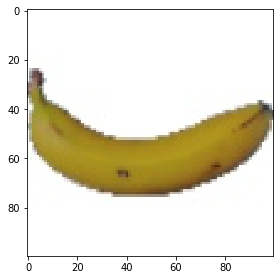

In [12]:
#Xi = skimage.io.imread("D:/TQ/Fruits360/Test_Images/Red_Apple.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Apple Braeburn/r_63_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Pepper Green/100_100.jpg")
Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Banana/98_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Strawberry/321_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Apple Braeburn/321_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Pineapple Mini/r_231_100.jpg")

#Xi = skimage.transform.resize(Xi, (100,100)) 

skimage.io.imshow(Xi) # Show image before inception preprocessing

Xi = preprocess_input(Xi)


In [37]:
#skimage.io.imshow(np.uint8(Xi)/255.0)
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 120.779
  x[:, :, 2] += 120.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

Xi_reversed = deprocess_img(Xi)

In [14]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

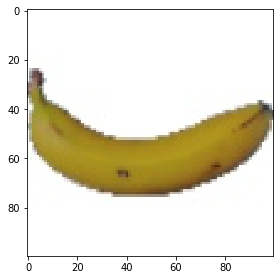

In [15]:
skimage.io.imshow(Xi_reversed)


In [16]:
preds = vgg_model.predict(Xi[np.newaxis,:,:,:])
#print(preds)
print(total_classes[np.argmax(preds)])

1/1 [==============================] - 0s 44ms/step
Banana


In [17]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes                #Index of top 5 classes

array([ 16,  81,  97,  18, 126], dtype=int64)

In [18]:
for x in top_pred_classes:
    print(total_classes[x])

Banana
Peach 2
Physalis
Banana Red
Tomato Maroon


# LIME Implementation

In [19]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = keras.utils.load_img(img_path, target_size=(100, 100))
        x = keras.utils.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)

1/1 [==============================] - 0s 35ms/step


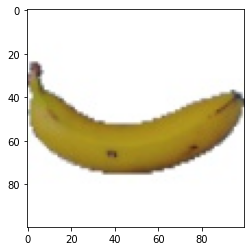

In [20]:
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Apple Braeburn/321_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/Test_Images/Red_Apple.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Apple Braeburn/r_63_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Pepper Green/100_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Banana/98_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Strawberry/321_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Apple Braeburn/321_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Pineapple Mini/r_231_100.jpg")

images = transform_img_fn([os.path.join('D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Pineapple Mini/','r_231_100.jpg')])
images = transform_img_fn([os.path.join('D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Banana/','98_100.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(deprocess_img(images[0]))
preds = vgg_model.predict(images)
#for x in preds:
 #   print(x)

In [21]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes                #Index of top 5 classes

array([ 16,  81,  97,  18, 126], dtype=int64)

In [22]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [23]:
explainer = lime_image.LimeImageExplainer()

In [24]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), vgg_model.predict, top_labels=5, hide_color=0, num_samples=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
CPU times: total: 17.5 s
Wall time: 17 s


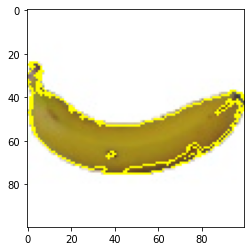

In [25]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=50, hide_rest=False)
plt.imshow(mark_boundaries(deprocess_img(temp), mask))  #from skimage.segmentation import mark_boundaries

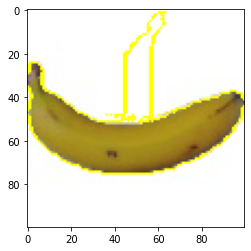

In [26]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry2 = mark_boundaries(deprocess_img(temp), mask)
plt.imshow(img_boundry2)

#plt.imshow(mark_boundaries((temp ).astype(np.uint8), mask))

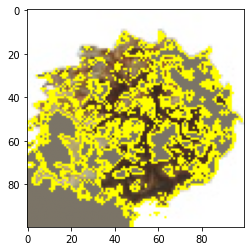

In [108]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(deprocess_img(temp), mask))

# Using LIME

In [37]:
import os
import keras

from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.9.0


In [38]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = keras.utils.load_img(img_path, target_size=(100, 100))
        x = keras.utils.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)

1/1 [==============================] - 0s 50ms/step


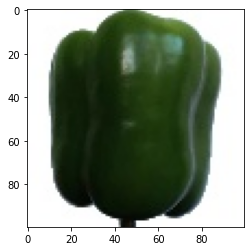

In [283]:
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Apple Braeburn/321_100.jpg")
#images = transform_img_fn([os.path.join('D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Strawberry/','321_100.jpg')])
images = transform_img_fn([os.path.join('D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Pepper Green/','100_100.jpg')])

#images = transform_img_fn([os.path.join('D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Apple Braeburn/','321_100.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(deprocess_img(images[0]))
preds = vgg_model.predict(images)
#for x in preds:
 #   print(x)

In [284]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes                #Index of top 5 classes

array([ 93,  95,  40,  39, 125], dtype=int64)

In [285]:
for x in top_pred_classes:
    print(total_classes[x])

Pepper Green
Pepper Red
Eggplant
Dates
Tomato Heart


In [273]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [274]:
explainer = lime_image.LimeImageExplainer()

In [275]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), vgg_model.predict, top_labels=5, hide_color=0, num_samples=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step
CPU times: total: 17.8 s
Wall time: 17.9 s


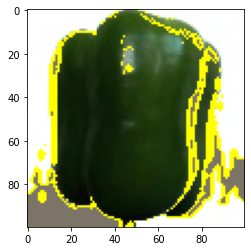

In [276]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=50, hide_rest=True)
plt.imshow(mark_boundaries(deprocess_img(temp), mask))  #from skimage.segmentation import mark_boundaries

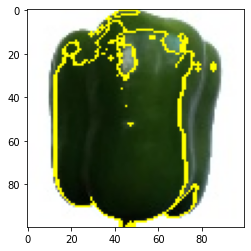

In [277]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry2 = mark_boundaries(deprocess_img(temp), mask)
plt.imshow(img_boundry2)

#plt.imshow(mark_boundaries((temp ).astype(np.uint8), mask))

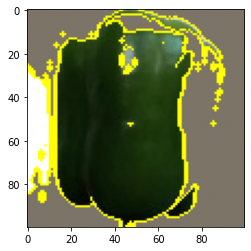

In [278]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(deprocess_img(temp), mask))

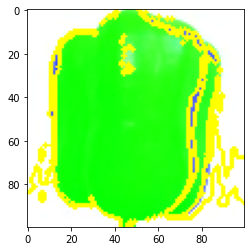

In [279]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=100, hide_rest=False)
plt.imshow(mark_boundaries(deprocess_img(temp), mask))

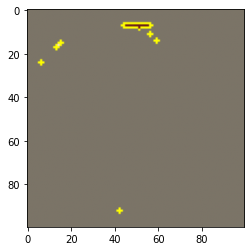

In [51]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(deprocess_img(temp), mask))

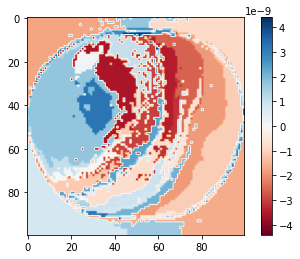

In [53]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[1]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
#plt.imshow(mark_boundaries(deprocess_img(temp), mask))